In [1]:
%load_ext autoreload
%autoreload 2
sys.path.append("..")   # fix to import modules from root
from src.general_imports import *
from src import modelling

# import logging
# logger = logging.getLogger('pymc')
# logger.propagate = False
# logger.setLevel(logging.ERROR)

# N_SITES =  7

amdata = amdata.AnnMethylData('../exports/wave3_linear.h5ad')
# amdata = amdata[amdata.sites.sort_values('r2', ascending=False).index[:N_SITES]]

In [113]:
# sort participants by age
amdata = amdata[:, np.argsort(amdata[0].participants.age)]

In [3]:
import pymc as pm
import arviz as az

In [6]:
def vect_linear_site(amdata):
    ages = np.broadcast_to(amdata.participants.age, shape=(amdata.n_sites, amdata.n_participants)).T
    coords = {'sites': amdata.sites.index.values,
            'participants': amdata.participants.index.values}


    with pm.Model(coords=coords) as model:

        # Define priors
        mean_slope = pm.Uniform("mean_slope", lower=-1/100, upper=1/100, dims='sites')
        mean_inter = pm.Uniform("mean_inter", lower=0, upper=1, dims='sites')
        var_inter = pm.Uniform("var_inter", lower=0, upper=1/10, dims='sites')
        
        # model mean and variance
        mean = mean_slope*ages + mean_inter
        variance = var_inter

        pm_data = pm.Data("data", amdata.X.T, dims=("participants", "sites"), mutable=True)

        # Define likelihood
        likelihood = pm.Normal("m-values",
            mu = mean,
            sigma = np.sqrt(variance),
            observed = pm_data)

        trace = pm.sample(cores=1, progressbar=True)
        max_p = pm.find_MAP(progressbar=True)

    return trace, max_p

def vect_chem_site(amdata):
    ages = np.broadcast_to(amdata.participants.age, shape=(amdata.n_sites, amdata.n_participants)).T
    coords = {'sites': amdata.sites.index.values,
            'participants': amdata.participants.index.values}
            
    with pm.Model(coords=coords) as model:

        # Define priors
        nu_0 = pm.Uniform("nu_0", lower=0, upper=0.1, dims='sites')
        nu_1 = pm.Uniform("nu_1", lower=0, upper=0.1, dims='sites')
        p = pm.Uniform("init_meth", lower=0, upper=1, dims='sites')
        var_init = pm.Uniform("var_init", lower=0, upper=1_000_000, dims='sites')
        N = pm.Uniform('system_size', lower= 1, upper=1_000_1000, dims='sites')


        # Useful variables
        omega = nu_0 + nu_1
        eta_0 = nu_0/omega
        eta_1 = nu_1/omega
        
        # model mean and variance
        var_term_0 = eta_0*eta_1
        var_term_1 = (1-p)*np.power(eta_0,2) + p*np.power(eta_1,2)

        mean = eta_0 + np.exp(-omega*ages)*((p-1)*eta_0 + p*eta_1)

        variance = (var_term_0/N 
                + np.exp(-omega*ages)*(var_term_1-var_term_0)/N 
                + np.exp(-2*omega*ages)*(var_init/np.power(N,2) - var_term_1/N)
            )

        # mean = eta_0 + np.exp(-omega*ages)*((p-1)*eta_0 + p*eta_1)

        # var_term_0 = eta_0*eta_1
        # var_term_1 = (1-p)*np.power(eta_0,2) + p*np.power(eta_1,2)


        # variance = (var_term_0/N 
        #         + np.exp(-omega*ages)*(var_term_1-var_term_0)/N 
        #         + np.exp(-2*omega*ages)*(var_init/np.power(N,2) - var_term_1/N)
        #     )
        pm_data = pm.Data("data", amdata.X.T, dims=("participants", "sites"), mutable=True)

        # Define likelihood
        likelihood = pm.Beta("m-values",
            mu = mean,
            sigma = np.sqrt(variance),
            observed = pm_data)

        trace = pm.sample(cores=4, progressbar=True)
        max_p = pm.find_MAP(progressbar=True)

    return trace, max_p

In [30]:
trace, max_p = vect_chem_site(amdata[1])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu_0, nu_1, init_meth, var_init, system_size]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 96 seconds.


array([[<AxesSubplot: title={'center': 'nu_0'}>,
        <AxesSubplot: title={'center': 'nu_0'}>],
       [<AxesSubplot: title={'center': 'nu_1'}>,
        <AxesSubplot: title={'center': 'nu_1'}>],
       [<AxesSubplot: title={'center': 'init_meth'}>,
        <AxesSubplot: title={'center': 'init_meth'}>],
       [<AxesSubplot: title={'center': 'var_init'}>,
        <AxesSubplot: title={'center': 'var_init'}>],
       [<AxesSubplot: title={'center': 'system_size'}>,
        <AxesSubplot: title={'center': 'system_size'}>]], dtype=object)

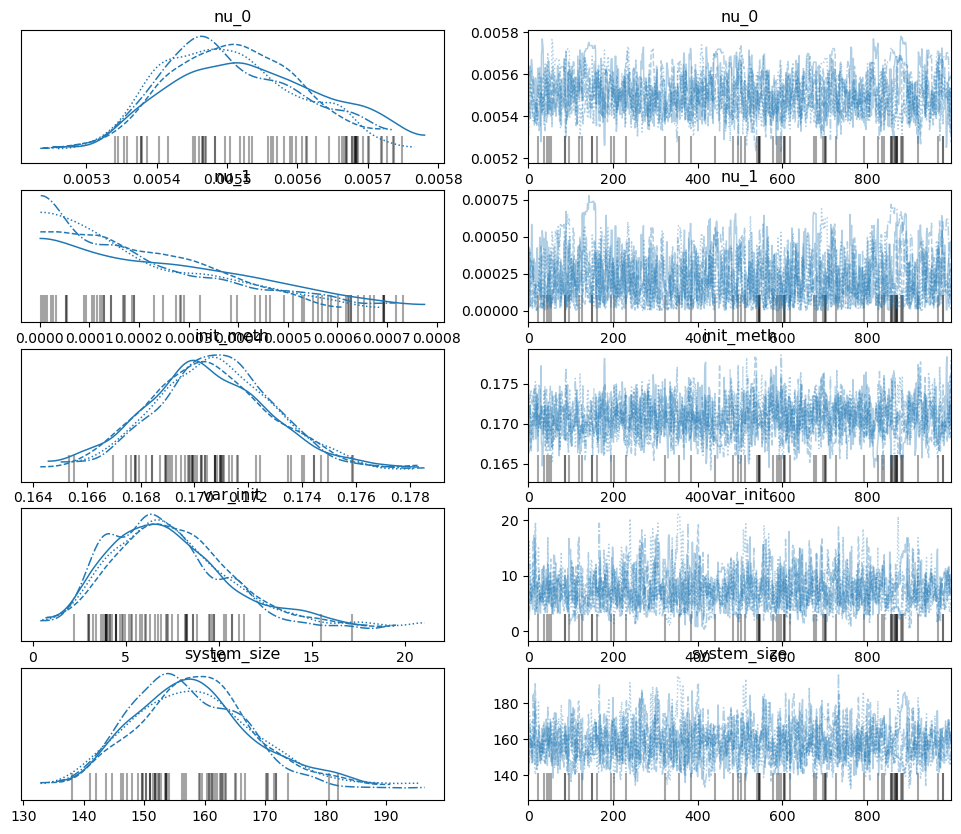

In [31]:
az.plot_trace(trace)

In [33]:
trace_summary = az.summary(trace)
var_mean = trace_summary['mean']
var_map = [max_p['nu_0'],
           max_p['nu_1'],
           max_p['init_meth'],
           max_p['var_init'],
           max_p['system_size']]

(0.0, 1.0)

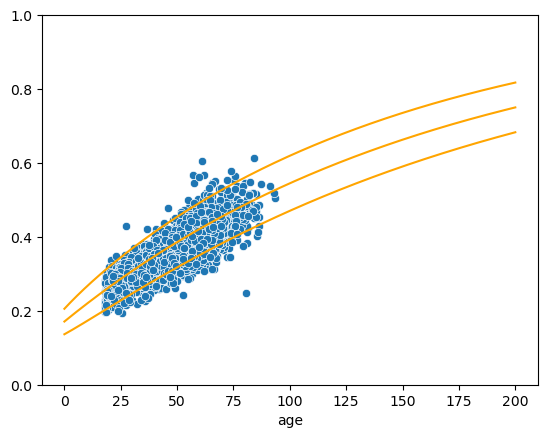

In [35]:
def chemical_plot (nu_0, nu_1, p, var_init, N, site=None):
  omega = nu_0 + nu_1
  eta_0 = nu_0/omega
  eta_1 = nu_1/omega

  t= np.linspace(0,200, 1_000)
  mean = eta_0 + np.exp(-omega*t)*((p-1)*eta_0 + p*eta_1)

  var_term_0 = eta_0*eta_1
  var_term_1 = (1-p)*np.power(eta_0,2) + p*np.power(eta_1,2)


  var = (var_term_0/N 
          + np.exp(-omega*t)*(var_term_1-var_term_0)/N 
          + np.exp(-2*omega*t)*(var_init/np.power(N,2) - var_term_1/N)
        )

  sns.lineplot(x=t, y=mean, color='orange')
  sns.lineplot(x=t, y=mean+2*np.sqrt(var), color='orange')
  sns.lineplot(x=t, y=mean-2*np.sqrt(var), color='orange')

  if site != None:
    sns.scatterplot(x=amdata[site].participants.age, y=amdata[site].X.flatten())
  # sns.lineplot(x=t, y=mean_linear, color='orange')
  # sns.lineplot(x=t, y=mean_linear+2*np.sqrt(var_linear), color='orange')
  # sns.lineplot(x=t, y=mean_linear-2*np.sqrt(var_linear), color='orange')


# params = [max_p['nu_0'], max_p['nu_1'], max_p['var_init'], max_p['init_meth'],  max_p['system_size']]

chemical_plot(*list(var_mean), site=1)
plt.ylim(0,1)